In [2]:
import os
from nuplan.common.maps.nuplan_map.map_factory import get_maps_api
map_name = 'us-nv-las-vegas-strip'
version = "nuplan-maps-v1.0"
map_api = get_maps_api(os.environ["NUPLAN_MAPS_ROOT"], version, map_name)

### nuplan map properties

- Length between points: max is 0.25m, min can be very small.
- Length of lane and lane connector: min max has no restriction, i.e. (1.4, 68.8)
- number of point aren't fixed, variant from i.e. (33, 243)

In [ ]:
# ['LANE', 'LANE_CONNECTOR']
from nuplan.common.actor_state.state_representation import Point2D
from nuplan.common.maps.abstract_map import AbstractMap, SemanticMapLayer
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

ego_position = Point2D(664400.8243663389, 3997340.684859042)

nearest_vector_map = map_api.get_proximal_map_objects(
    layers=[SemanticMapLayer['LANE'], SemanticMapLayer['LANE_CONNECTOR']],
    point=ego_position,
    radius=50,
)

def calculate_length(line):
    points_len = line.shape[0]
    line_length = []
    for i in range(1, points_len):
        line_length.append(np.sqrt((line[i,0] - line[i-1,0])**2 + (line[i,1] - line[i-1,1])**2))
    line_length = np.array(line_length)
    print("seg min", line_length.min(), "seg max", line_length.max())
    return line_length.sum()

# reduce the number of points in a line, with a maximun interval of 1 meter.
def reduce_points(line, interval = 1):
    new_line = []
    points_len = line.shape[0]
    new_line.append(line[0])

    summed_length = 0
    for i in range(1, points_len - 1):
        summed_length += np.sqrt((line[i,0] - line[i-1,0])**2 + (line[i,1] - line[i-1,1])**2)
        if summed_length > interval:
            new_line.append(line[i])
            summed_length = 0
    new_line.append(line[-1])
    return np.array(new_line)

geometry = nearest_vector_map[SemanticMapLayer['LANE']]
_object_coords = [element.baseline_path.linestring.coords.xy for element in geometry]
object_coords = [np.vstack(coords).T for coords in _object_coords]
min_length = 999
max_length = 0
min_line_length = 999
max_line_length = 0
plt.figure(figsize=(20,20))
plt.scatter(ego_position.x, ego_position.y, marker="*")
for line in object_coords:
    reduced_line = reduce_points(line)

    plt.plot(reduced_line[:, 0], reduced_line[:, 1], c=(0, 0, 0), alpha=0.3)
    if len(line) < min_length:
        min_length = len(line)
    if len(line) > max_length:
        max_length = len(line)
    
    line_length = calculate_length(line)
    if line_length < min_line_length:
        min_line_length = line_length
    if line_length > max_line_length:
        max_line_length = line_length
print("lane min data len:", min_length, "lane max data len:", max_length)
print("lane min len:", min_line_length, "lane max len:", max_line_length)


geometry = nearest_vector_map[SemanticMapLayer['LANE_CONNECTOR']]
_object_coords = [element.baseline_path.linestring.coords.xy for element in geometry]
object_coords = [np.vstack(coords).T for coords in _object_coords]
min_length = 999
max_length = 0
min_line_length = 999
max_line_length = 0
for line in object_coords:
    print("len line", len(line))
    reduced_line = reduce_points(line, 3)
    print("red line", len(reduced_line))
    plt.plot(reduced_line[:, 0], reduced_line[:, 1], c=(random.random(), random.random(), random.random()), alpha=1)
    if len(line) < min_length:
        min_length = len(line)
    if len(line) > max_length:
        max_length = len(line)

    line_length = calculate_length(line)
    if line_length < min_line_length:
        min_line_length = line_length
    if line_length > max_line_length:
        max_line_length = line_length
print("lane min data len:", min_length, "lane max data len:", max_length)
print("lane min len:", min_line_length, "lane max len:", max_line_length)

plt.show()

### Get distance to nearest lane(In routing)

65777
2.302729044134826
10.31344764464901
5.637758307309981
2.200210473242624
6.747108907693799
65782
18.57989337877971
21.40050682863012
20.608125131308547
18.030332569924667
66789
[[-17.73060676921159, 7.312592164147645], [-17.51568871922791, 7.18488185107708], [-17.301758027169853, 7.055524398107082], [-17.088827311526984, 6.924527436494827], [-16.876909144222736, 6.791898698080331], [-16.6660160231404, 6.657646009232849], [-16.45616039726883, 6.521777289919555], [-16.24735464854166, 6.384300558362156], [-16.03961109695956, 6.245223927311599], [-15.832942001521587, 6.104555600788444], [-15.62735955696553, 5.96230388386175], [-15.422875893767923, 5.8184771672822535], [-15.219503079075366, 5.673083937726915], [-15.017253114841878, 5.526132775470614], [-14.816137931775302, 5.377632352057844], [-14.61616939958185, 5.2275914289057255], [-14.417238759808242, 5.076176535803825], [-14.217683661263436, 4.925586181227118], [-14.016977679915726, 4.776533163618296], [-13.815132657531649, 4.6290

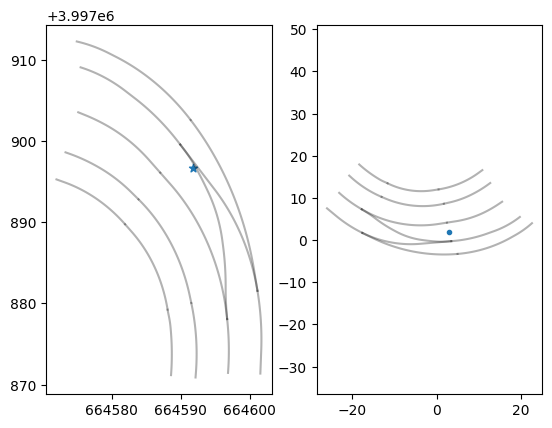

In [2]:

from nuplan.common.maps.abstract_map import AbstractMap, SemanticMapLayer
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
from nuplan.common.geometry.convert import relative_to_absolute_poses, absolute_to_relative_poses
from nuplan.common.actor_state.state_representation import StateVector2D, TimePoint, TimeDuration, Point2D, StateSE2
from shapely.geometry import LineString

VELO_MPS = 5
TIME = 3

route_ids = ['65782', '66789', '65777', '66424', '65778', '66758', '65772', '66670', '65552', '66814', 
             '65624', '67050', '48881', '60109', '47004', '66405', '65419', '66969', '65481', '60208', 
             '48680', '66191', '66141', '67094', '65488', '66310', '65554', '60178', '46864', '66971']

def map_absolute_to_relative(reference, absolute_states):
    to_transform = [reference] + absolute_states
    transformed_states = absolute_to_relative_poses(to_transform)
    assert len(transformed_states[1:]) == len(absolute_states)
    return transformed_states[1:]

import shapely.geometry as geom
ego_position = Point2D(664591.8370918378, 3997896.634053245)
geom_point = geom.Point(3.0, 2.0)
heading =2.218830745481191

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.scatter(ego_position.x, ego_position.y, marker="*")
ax2.scatter(geom_point.x, geom_point.y, marker=".")



nearest_vector_map = map_api.get_proximal_map_objects(
    layers=[SemanticMapLayer['ROADBLOCK'], SemanticMapLayer['ROADBLOCK_CONNECTOR']],
    point=ego_position,
    radius=VELO_MPS * TIME,
)

min_dist = 10000

road_blocks = nearest_vector_map[SemanticMapLayer['ROADBLOCK']]
for rb in road_blocks:
    if rb.id in route_ids:
        print(rb.id)
        for lane in rb.interior_edges:
            lane_points = []
            x,y = lane.baseline_path.linestring.coords.xy
            ax1.plot(x,y, c=(0, 0, 0), alpha=0.3)
            for i in range(len(x)):
                lane_points.append(StateSE2.deserialize([x[i], y[i], 0]))
            ego_state = StateSE2.deserialize([ego_position.x, ego_position.y, heading])
            transformed_points = map_absolute_to_relative(ego_state, lane_points)
            
            transformed_line = []
            for point in transformed_points:
                transformed_line.append([point.x, point.y])

            transformed_line = np.array(transformed_line)
            ax2.plot(transformed_line[:,0], transformed_line[:,1], c=(0, 0, 0), alpha=0.3)

            line_string = LineString(transformed_line)

            to_line_dis = geom_point.distance(line_string)
            if to_line_dis < min_dist:
                min_dist = to_line_dis
            print(to_line_dis)


road_blocks_connectors = nearest_vector_map[SemanticMapLayer['ROADBLOCK_CONNECTOR']]


for rbc in road_blocks_connectors:
    if rbc.id in route_ids:
        print(rbc.id)
        for lane in rbc.interior_edges:
            lane_points = []
            x,y = lane.baseline_path.linestring.coords.xy
            ax1.plot(x,y, c=(0, 0, 0), alpha=0.3)
            for i in range(len(x)):
                lane_points.append(StateSE2.deserialize([x[i], y[i], 0]))
            ego_state = StateSE2.deserialize([ego_position.x, ego_position.y, heading])
            transformed_points = map_absolute_to_relative(ego_state, lane_points)
            
            transformed_line = []
            for point in transformed_points:
                transformed_line.append([point.x, point.y])
            print(transformed_line)
            transformed_line = np.array(transformed_line)
            ax2.plot(transformed_line[:,0], transformed_line[:,1], c=(0, 0, 0), alpha=0.3)

            line_string = LineString(transformed_line)

            to_line_dis = geom_point.distance(line_string)
            if to_line_dis < min_dist:
                min_dist = to_line_dis
            print(to_line_dis)
print("min_dist:", min_dist)
plt.axis('equal')
plt.show()



# id, dis = map_api.get_distance_to_nearest_map_object(ego_position, SemanticMapLayer['LANE'])
# print(id, dis)
# id, dis = map_api.get_distance_to_nearest_map_object(ego_position, SemanticMapLayer['LANE_CONNECTOR'])
# print(id, dis)

### Sparsed map elements test

seg min 0.0490062450686822 seg max 0.25000000114980137
seg min 0.20196670934450991 seg max 0.25000000137500494
seg min 0.08418844699144575 seg max 0.25000000225047037
seg min 0.09798182396370725 seg max 0.2499999953228575
seg min 0.19586834369164602 seg max 0.24999999018746383
seg min 0.18616464417165468 seg max 0.25000000251483695
seg min 0.10418043802038088 seg max 0.2500000015515201
seg min 0.13794837957795236 seg max 0.2500000025574077
seg min 0.03587107592288095 seg max 0.2500000019877054
seg min 0.041149163116330656 seg max 0.25000000723650917
seg min 0.11822989236122196 seg max 0.2500000159691731
seg min 0.17555395697534568 seg max 0.25000000080819895
seg min 0.19379207922318903 seg max 0.25000000001710854
seg min 0.13936073924123416 seg max 0.24999952114755575
seg min 0.1898349668575563 seg max 0.25000000231624964
seg min 0.03229682712262847 seg max 0.2500000018617005
seg min 0.13388869377186263 seg max 0.25000000233337716
seg min 0.06992014172770598 seg max 0.2500000019072189


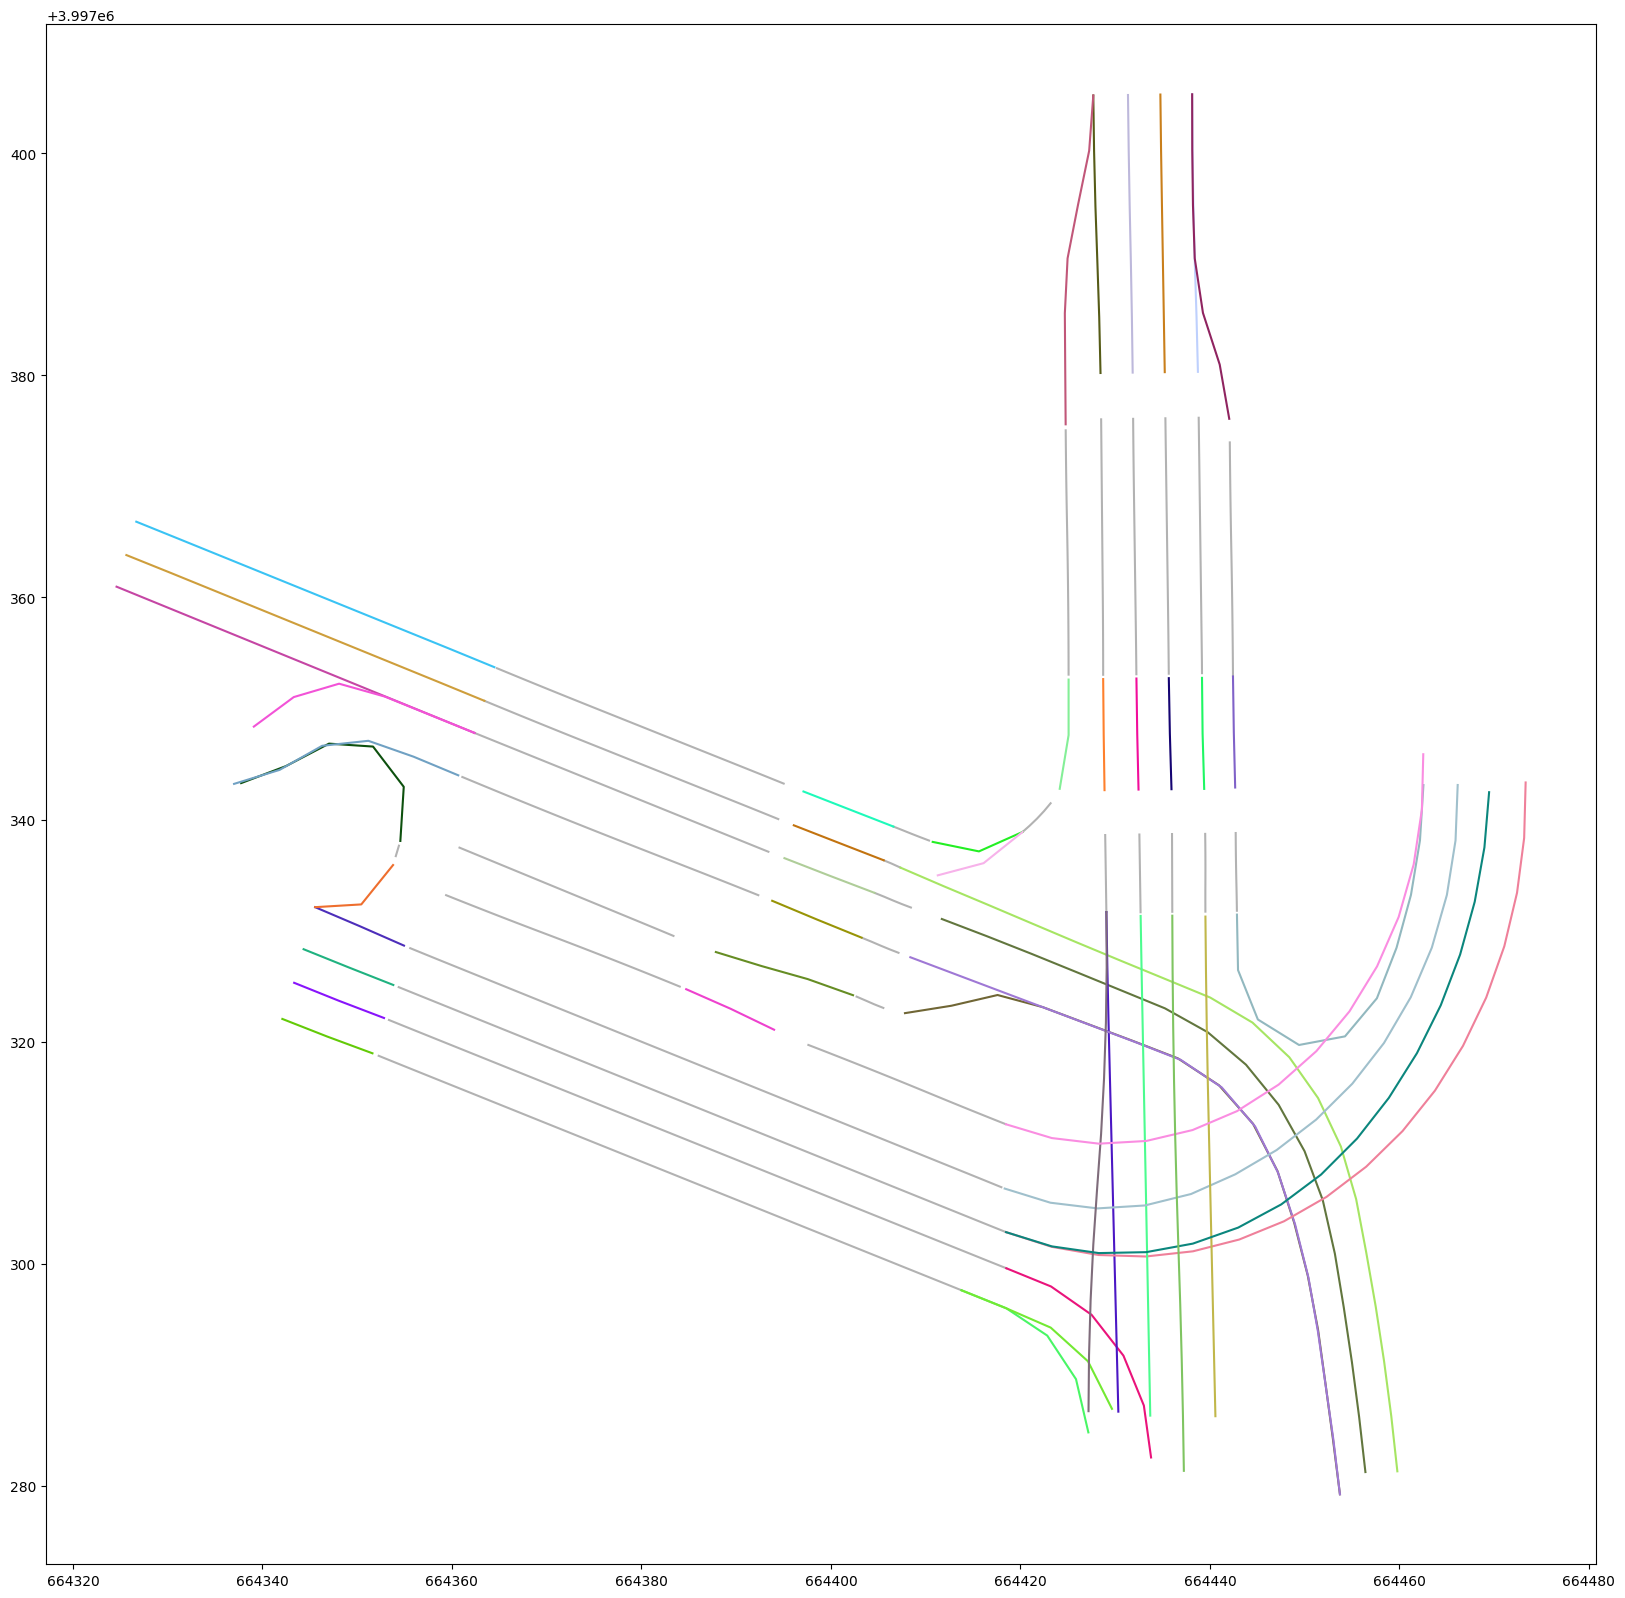

In [3]:
# ['LANE', 'LANE_CONNECTOR']
from nuplan.common.actor_state.state_representation import Point2D
from nuplan.common.maps.abstract_map import AbstractMap, SemanticMapLayer
import numpy as np
import matplotlib.pyplot as plt
import random

ego_position = Point2D(664400.8243663389, 3997340.684859042)

nearest_vector_map = map_api.get_proximal_map_objects(
    layers=[SemanticMapLayer['LANE'], SemanticMapLayer['LANE_CONNECTOR']],
    point=ego_position,
    radius=50,
)

def calculate_length(line):
    points_len = line.shape[0]
    line_length = []
    for i in range(1, points_len):
        line_length.append(np.sqrt((line[i,0] - line[i-1,0])**2 + (line[i,1] - line[i-1,1])**2))
    line_length = np.array(line_length)
    print("seg min", line_length.min(), "seg max", line_length.max())
    return line_length.sum()

geometry = nearest_vector_map[SemanticMapLayer['LANE']]
_object_coords = [element.baseline_path.linestring.coords.xy for element in geometry]
object_coords = [np.vstack(coords).T for coords in _object_coords]
min_length = 999
max_length = 0
min_line_length = 999
max_line_length = 0
plt.figure(figsize=(20,20))
for line in object_coords:
    plt.plot(line[::4, 0], line[::4, 1], c=(0, 0, 0), alpha=0.3)
    if len(line) < min_length:
        min_length = len(line)
    if len(line) > max_length:
        max_length = len(line)
    
    line_length = calculate_length(line)
    if line_length < min_line_length:
        min_line_length = line_length
    if line_length > max_line_length:
        max_line_length = line_length
print("lane min data len:", min_length, "lane max data len:", max_length)
print("lane min len:", min_line_length, "lane max len:", max_line_length)


geometry = nearest_vector_map[SemanticMapLayer['LANE_CONNECTOR']]
_object_coords = [element.baseline_path.linestring.coords.xy for element in geometry]
object_coords = [np.vstack(coords).T for coords in _object_coords]
min_length = 999
max_length = 0
min_line_length = 999
max_line_length = 0
for line in object_coords:
    plt.plot(line[0::20, 0], line[0::20, 1], c=(random.random(), random.random(), random.random()), alpha=1)
    if len(line) < min_length:
        min_length = len(line)
    if len(line) > max_length:
        max_length = len(line)

    line_length = calculate_length(line)
    if line_length < min_line_length:
        min_line_length = line_length
    if line_length > max_line_length:
        max_line_length = line_length
print("lane min data len:", min_length, "lane max data len:", max_length)
print("lane min len:", min_line_length, "lane max len:", max_line_length)

plt.show()

### RoutingTest

Function for generating lane-level routes from route-level routes

664588.5991640675 3997871.181925584
664588.619990598 3997871.4310558313
664588.638700776 3997871.6803539535
664588.6552932541 3997871.929801972
664588.6697668377 3997872.1793818986
664588.6821204775 3997872.429075734
664588.6923532889 3997872.678865473
664588.7004645318 3997872.9287331034
664588.70645362 3997873.1786606037
664588.7103201204 3997873.42862995
664588.7120637586 3997873.6786231184
664588.7116844043 3997873.92862208
664588.7091820874 3997874.1786088045
664588.7045569895 3997874.4285652675
664588.6978094405 3997874.6784734405
664588.6889399311 3997874.9283153024
664588.6779490961 3997875.178072838
664588.6648377326 3997875.4277280318
664588.6496067846 3997875.677262885
664588.6322573493 3997875.926659399
664588.612790677 3997876.175899591
664588.5912081762 3997876.4249654864
664588.5675113994 3997876.6738391235
664588.5425935031 3997876.922594219
664588.5382744351 3997876.9656992685
664588.5104603592 3997877.214141542
664588.4768793236 3997877.4618702256
664588.4375494712 39

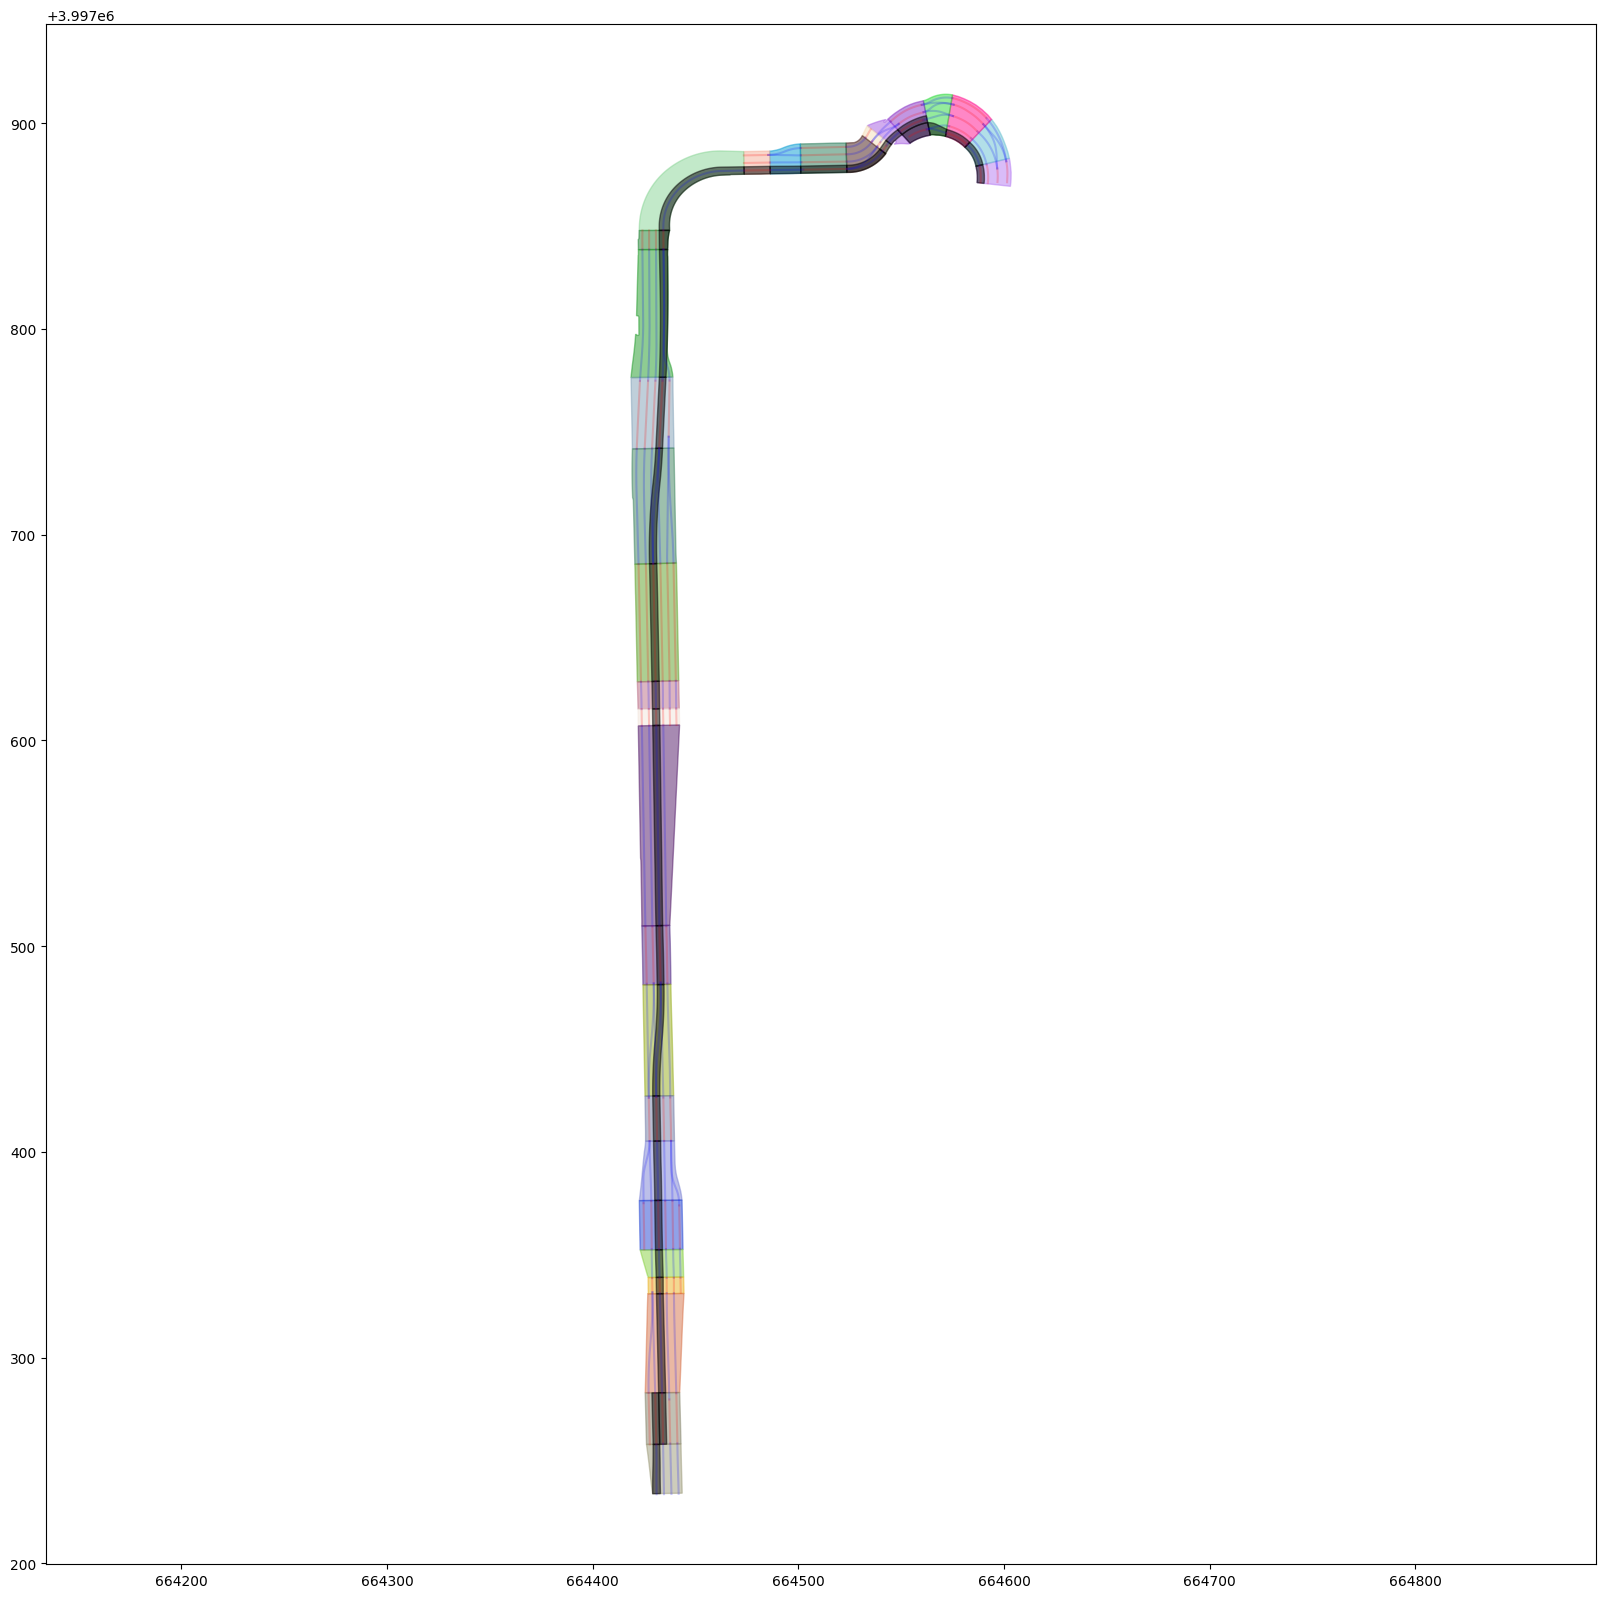

In [6]:
import random
from nuplan.common.maps.abstract_map import AbstractMap, SemanticMapLayer
import matplotlib.pyplot as plt
from queue import PriorityQueue

route_ids = ['65782', '66789', '65777', '66424', '65778', '66758', '65772', '66670', '65552', '66814', 
             '65624', '67050', '48881', '60109', '47004', '66405', '65419', '66969', '65481', '60208', 
             '48680', '66191', '66141', '67094', '65488', '66310', '65554', '60178', '46864', '66971']

class LaneNode:
    def __init__(self, id, road_block_id) -> None:
        self.id = id
        self.road_block_id = road_block_id
        self.next_nodes = {}
        self.cost = 0.0
        self.pre_node = None

    def add_next_node(self, next_node_id, type):
        self.next_nodes[next_node_id] = type

    def get_next_nodes(self, node_list):
        next_nodes = []
        for next_node_id in self.next_nodes.keys():
            # There may be next node not in the node list, which is normal because this graph is not closed.
            if next_node_id in node_list:
                next_node = node_list[next_node_id]
                if self.next_nodes[next_node_id] == "adj":
                    next_node.cost = self.cost + 2.0
                else:
                    next_node.cost = self.cost + 0.1

                next_nodes.append(next_node)
        return next_nodes

def DFS(start_node_id, end_node_id, node_list):
    open_set = dict()
    close_set = dict()

    open_pq = PriorityQueue()
    open_pq.put((0.0, start_node_id))

    explored_node_num = 0
    while(not open_pq.empty()):
        current_id = open_pq.get()[1]
        current_node = node_list[current_id]
        close_set[current_id] = current_node

        next_nodes = current_node.get_next_nodes(node_list)
        for next_node in next_nodes:
            if next_node.id in close_set:
                continue

            if next_node.id in open_set:
                if next_node.cost < open_set[next_node.id].cost:
                    open_set[next_node.id].pre_node = current_id
                    open_set[next_node.id].cost = next_node.cost
            else:
                explored_node_num += 1
                next_node.pre_node = current_id
                open_set[next_node.id] = next_node
                open_pq.put((next_node.cost, next_node.id))
    
    if node_list[end_node_id].pre_node is None:
        raise RuntimeError("can not find a path from start node to end node")
    print("DFS explored node num:", explored_node_num)

def BackTrace(end_node_id, node_list):
    path = []
    current_node = node_list[end_node_id]
    while(current_node.pre_node is not None):
        path.append(current_node.id)
        current_node = node_list[current_node.pre_node]
    path.append(current_node.id)
    return path

plt.figure(figsize=(20,20))
plt.axis('equal')

node_list = {}
id_lane_map = {}

color = "red"
for roadblock_id in route_ids:
    map_obj = map_api.get_map_object(roadblock_id, SemanticMapLayer['ROADBLOCK'])
    if map_obj is None:
        map_obj = map_api.get_map_object(roadblock_id, SemanticMapLayer['ROADBLOCK_CONNECTOR'])
        if map_obj is None:
            raise RuntimeError("the roadblock is not in the map")
    
    # switch the lane color between blue and red
    for edge in map_obj.interior_edges:
        node = LaneNode(edge.id, roadblock_id)

        adj_edge: tuple = edge.adjacent_edges
        '''
        Explain of the introduce of switch symbol.
        Switching symbol is a value switching between 0 and 1 with the change of roadblock
        To avoid the successive lane changing in same segment, we disable the connective by halving it.
        For example, lane 0 can only left, 1-right, 2-left, 3-right.
        At the same time, if we take same index principle for all the segment, the vehicle gets stuck.
        So we need to switch the rule between successive lanes.
        The effect is like the image. Note this will causing routing failure if the number of segments is very low.
        Better to achieve this with cost, but dont know how to do for now.
        > < > <
        < > < >
        '''
        switching_symbol = color == 'red'
        index = (map_obj.interior_edges.index(edge) + switching_symbol) % 2
        if adj_edge[index] is not None:
            node.add_next_node(adj_edge[index].id, "adj")
        
        outgoing_edges = edge.outgoing_edges
        for edge_out in outgoing_edges:
            node.add_next_node(edge_out.id, "next")
        node_list[edge.id] = node
        id_lane_map[edge.id] = edge

        x = edge.baseline_path.linestring.coords.xy[0]
        y = edge.baseline_path.linestring.coords.xy[1]
        for i in range(len(x)):
            print(x[i], y[i])

        # visualize the lane
        if color == "red":
            plt.plot(*edge.baseline_path.linestring.coords.xy, c=(1.0, 0, 0), alpha=0.2)
        else:
            plt.plot(*edge.baseline_path.linestring.coords.xy, c=(0, 0, 1.0), alpha=0.2)
    color = "blue" if color == "red" else "red"
    plt.fill(*map_obj.polygon.exterior.xy, c=(random.random(), random.random(), random.random()), alpha=0.5) # polygon.xy return tuple of x and y coordinates.


# start id 68566, end id 68762
print(node_list)
DFS("68566", "68762", node_list)
for node_id in node_list:
    if node_list[node_id].pre_node is None:
        print(node_id)
path = BackTrace("68762", node_list)
for id in path:
    edge = id_lane_map[id]
    plt.fill(*edge.polygon.exterior.xy, c=(0, 0.0, 0), alpha=0.5)